## Import CLIP output for all stimuli

In [1]:
import pandas as pd

# clip all results is a pickle file in the same directory as this notebook
df = pd.read_pickle("clip_all_results.pickle")
df.head()

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff
0,../VALSE_data/images/coco2017/000000462576.jpg,Breakfast items including juice are on the table.,Breakfast items including juice are off the ta...,relations,31.603619,31.473452,0.130167
1,../VALSE_data/images/coco2017/000000294162.jpg,The white laptop is turned off but left open.,The white laptop is turned on but left open.,relations,28.649076,28.661810,-0.012733
2,../VALSE_data/images/coco2017/000000144333.jpg,a girl is sitting on a bicycle outside,A girl is sitting behind a bicycle outside,relations,33.161629,32.149235,1.012394
3,../VALSE_data/images/coco2017/000000181666.jpg,The nomadic sheepherd walks behind a large gro...,The nomadic sheepherd walks on a large group o...,relations,32.504292,32.218952,0.285339
4,../VALSE_data/images/coco2017/000000482436.jpg,The woman in the diner and the man looking int...,The woman outside the diner and the man lookin...,relations,29.805805,28.846434,0.959372


**Which categories are represented?** We expect actions, existence, relations

In [2]:
df.groupby('linguistic_phenomena').size()

linguistic_phenomena
actions      1597
existence     505
relations     535
dtype: int64

## Separate stimuli into groups by performance (clip_pred_diff value) and category

First, calculate the thresholds of 33rd and 66th percentile for each linguistic category

In [3]:
thresholds = df.groupby('linguistic_phenomena')['clip_pred_diff'].quantile([0.33, 0.66])
thresholds = thresholds
thresholds


linguistic_phenomena      
actions               0.33    0.330514
                      0.66    1.850014
existence             0.33    0.069525
                      0.66    0.924227
relations             0.33   -0.011719
                      0.66    0.497886
Name: clip_pred_diff, dtype: float64

We compare this to the visual respresentation of this distribution and it seems to match:

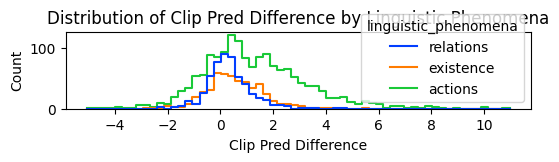

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 1))
sns.histplot(data=df, x='clip_pred_diff', hue='linguistic_phenomena', element='step', fill=False, common_norm=False, palette='bright')
plt.title('Distribution of Clip Pred Difference by Linguistic Phenomena')
plt.xlabel('Clip Pred Difference')
plt.ylabel('Count')
plt.show()

Now sort each group into one of three groups by whether they are in bottom, middle, or top division

In [5]:
def categorize_performance(row, low_percentile = 0.33, high_percentile = 0.66):
    """For a row from the dataframe, assign low/medium/high performance 
    based on comparing the clip_pred_diff to the thresholds for that linguistic phenomena"""

    if row['clip_pred_diff'] <= thresholds[row['linguistic_phenomena']][low_percentile]:
        return "low_perf"
    elif row['clip_pred_diff']<=thresholds[row['linguistic_phenomena']][high_percentile]:
        return "medium_perf"
    else:
        return "high_perf"
    
df['performance_group'] = [categorize_performance(row) for _, row in df.iterrows()]

See how many elements are in each group. We expect the performance groups to be roughly equal within each category

In [6]:
df.groupby(['linguistic_phenomena', 'performance_group']).size()

linguistic_phenomena  performance_group
actions               high_perf            543
                      low_perf             527
                      medium_perf          527
existence             high_perf            172
                      low_perf             167
                      medium_perf          166
relations             high_perf            182
                      low_perf             177
                      medium_perf          176
dtype: int64

### Sample 20 stimuli from each combination of phenomena and performance

In [7]:
# create list of sampled dataframes (one for each set of attributes)
sampled_dfs = []
for phenomena in df['linguistic_phenomena'].unique():
    for group in ['low_perf', 'medium_perf', 'high_perf']:
        samples = df[(df['linguistic_phenomena'] == phenomena) & (df['performance_group'] == group)].sample(n=20)
        sampled_dfs.append(samples)

# combine into a single dataframe
prelim_samples = pd.concat(sampled_dfs)
prelim_samples

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
132,../VALSE_data/images/coco2017/000000465430.jpg,Two sandwiches on Rye bread sit on a foil cove...,Two sandwiches on rye bread sit beside a foil ...,relations,33.405823,33.589836,-0.184013,low_perf
318,../VALSE_data/images/coco2017/000000476415.jpg,A guy wearing a tie has his hands in his pockets.,A guy wearing a tie has his hands from his poc...,relations,29.870935,30.287960,-0.417025,low_perf
120,../VALSE_data/images/coco2017/000000460229.jpg,There is a truck behind the stop sign.,There is a truck on the stop sign.,relations,28.959253,29.668962,-0.709709,low_perf
299,../VALSE_data/images/coco2017/000000363072.jpg,The commuter train is headed toward the tall b...,The commuter train is headed past the tall bui...,relations,28.570499,29.872452,-1.301952,low_perf
356,../VALSE_data/images/coco2017/000000567432.jpg,A red airplane jet flies over power lines in a...,A red airplane jet flies through power lines i...,relations,32.593071,33.155514,-0.562443,low_perf
...,...,...,...,...,...,...,...,...
2066,../VALSE_data/images/swig/communicating_309.jpg,A man communicates with the people.,The people communicate with man.,actions,22.398169,20.155497,2.242672,high_perf
2502,../VALSE_data/images/swig/floating_338.jpg,A log floats in the water.,A water floats on a log.,actions,31.158346,27.547039,3.611307,high_perf
2565,../VALSE_data/images/swig/slipping_140.jpg,A man slips down the stairway.,A stairway slips behind the man.,actions,26.248833,22.712978,3.535854,high_perf
1346,../VALSE_data/images/swig/urinating_72.jpg,A dog urinates under a tree.,A dog slips under a tree.,actions,28.473564,26.604664,1.868900,high_perf


The counts for each set of attributes below should be 20:

In [8]:
prelim_samples.groupby(['linguistic_phenomena', 'performance_group']).size()

linguistic_phenomena  performance_group
actions               high_perf            20
                      low_perf             20
                      medium_perf          20
existence             high_perf            20
                      low_perf             20
                      medium_perf          20
relations             high_perf            20
                      low_perf             20
                      medium_perf          20
dtype: int64

In [9]:
# prelim_samples.to_pickle("preliminary_sampled_stimuli.pickle")

## Load 45 more stimuli for each of actions, relations

In [10]:
original_stimuli_sample = pd.read_pickle("jan8_preliminary_sampled_stimuli.pickle")
original_stimuli_sample

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
468,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf
274,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109,low_perf
243,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933,low_perf
376,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064,low_perf
520,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092,low_perf
...,...,...,...,...,...,...,...,...
1412,../VALSE_data/images/swig/packaging_189.jpg,A young buck packages up a broom.,A young buck heaves up a broom.,actions,27.694311,22.859179,4.835133,high_perf
1550,../VALSE_data/images/swig/chasing_258.jpg,A hunter chases after a American bison.,A hunter forags after a American bison.,actions,37.372082,35.013138,2.358944,high_perf
1783,../VALSE_data/images/swig/tugging_29.jpg,A person tugs a power cord.,A power cord tugs on a person.,actions,24.806143,22.592257,2.213886,high_perf
1206,../VALSE_data/images/swig/coaching_90.jpg,A woman coaches people.,A woman reads people.,actions,28.184359,18.201620,9.982738,high_perf


In [13]:
# create list of sampled dataframes (one for each set of attributes)
df_excluding_original_samples = df[~df['img_path'].isin(original_stimuli_sample['img_path'])]

sampled_dfs = []
for phenomena in "actions", "relations":
    for group in ['low_perf', 'medium_perf', 'high_perf']:
        samples = df_excluding_original_samples[(df_excluding_original_samples['linguistic_phenomena'] == phenomena) & (df['performance_group'] == group)].sample(n=15)
        sampled_dfs.append(samples)

# combine into a single dataframe
prelim_samples_2 = pd.concat(sampled_dfs)
prelim_samples_2

/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/ipykernel_64366/4111641152.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_excluding_original_samples[(df_excluding_original_samples['linguistic_phenomena'] == phenomena) & (df['performance_group'] == group)].sample(n=15)
/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/ipykernel_64366/4111641152.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_excluding_original_samples[(df_excluding_original_samples['linguistic_phenomena'] == phenomena) & (df['performance_group'] == group)].sample(n=15)
/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/ipykernel_64366/4111641152.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_excluding_original_samples[(df_excluding_original_samples['linguistic_phenomena'] == phenomena) & (df['performance_group'] == group)].sample(n=15)
/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f8

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
1196,../VALSE_data/images/swig/speaking_84.jpg,A baby speaks on a telephone.,A baby sits on a telephone.,actions,28.024435,28.106859,-0.082424,low_perf
1974,../VALSE_data/images/swig/kicking_154.jpg,A soccer player kicks a soccer ball.,A soccer ball kicks a soccer player.,actions,25.842213,26.002712,-0.160500,low_perf
1635,../VALSE_data/images/swig/juggling_131.jpg,A ballplayer juggles a baseball.,A ballplayer disciplines a baseball.,actions,28.437281,28.478926,-0.041645,low_perf
1684,../VALSE_data/images/swig/pulling_192.jpg,A truck pulls a boat.,A truck punts a boat.,actions,26.245920,28.028925,-1.783005,low_perf
1042,../VALSE_data/images/swig/displaying_251.jpg,A man displays a certificate.,A man carries a certificate.,actions,27.329451,28.549372,-1.219921,low_perf
...,...,...,...,...,...,...,...,...
105,../VALSE_data/images/coco2017/000000116439.jpg,A person sits in a small boat on the water.,A person sits beside a small boat on the water.,relations,32.219311,31.050545,1.168766,high_perf
240,../VALSE_data/images/coco2017/000000057027.jpg,A baby elephant walks with an older elephant,A baby elephant walks past an older elephant,relations,29.852327,29.327898,0.524429,high_perf
225,../VALSE_data/images/coco2017/000000082807.jpg,A dog is sitting in a chair at a table.,A dog is sitting beside a chair at a table.,relations,30.186274,29.606693,0.579580,high_perf
355,../VALSE_data/images/coco2017/000000493019.jpg,A group of zebras are bending down and eating ...,A group of zebras are bending up and eating a ...,relations,36.196323,35.408810,0.787514,high_perf


In [14]:
prelim_samples_2.to_pickle("second_set_of_sampled_stimuli.pickle")